# Hate Speech Detection Using LSTM in PyTorch

In [101]:
import pandas as pd
import numpy as np

In [102]:
# Load dataset
df = pd.read_csv('labeled_data.csv')

df.shape

(24783, 7)

In [103]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

In [104]:
text = []
clas = []

text = df['tweet'].tolist()
clas = df['class'].tolist()

In [105]:
df = pd.DataFrame({'tweet': text, 'class': clas})

In [106]:
print(df.isnull().sum())

tweet    0
class    0
dtype: int64


In [107]:
df['tweet'] = df['tweet'].apply(lambda x:x.lower())

In [108]:
punctuation_signs = list("?:!.,;|")
remove_usernames = r'@([^\s]+)'
remove_hash_no = r'#\d+'

# Remove punctuation signs
for punct_sign in punctuation_signs:
    df['tweet'] = df['tweet'].str.replace(punct_sign, '', regex=True)

# Remove usernames
df['tweet'] = df['tweet'].str.replace(remove_usernames, '', regex=True)

# Remove hashtags with numbers
df['tweet'] = df['tweet'].str.replace(remove_hash_no, '', regex=True)

In [109]:
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("!", "")
df['tweet'] = df['tweet'].str.replace("'s", "")
df['tweet'] = df['tweet'].str.replace("'", "")
df['tweet'] = df['tweet'].str.replace("`", "")
df['tweet'] = df['tweet'].str.replace("https", "")
df['tweet'] = df['tweet'].str.replace("http", "")
df['tweet'] = df['tweet'].str.replace("rt", "")
df['tweet'] = df['tweet'].str.replace("-", "")

In [110]:
df['tweet']

0           as a woman you shouldnt complain about clea...
1           boy dats coldtyga dwn bad for cuffin dat ho...
2           dawg   you ever fuck a bitch and she sta to...
3                                   she look like a tranny
4           the shit you hear about me might be true or...
                               ...                        
24778    you a muthaf***in lie &   right his tl is tras...
24779    youve gone and broke the wrong hea baby and dr...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled  ntac eileen dahlia  beautiful color...
Name: tweet, Length: 24783, dtype: object

In [111]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '', regex=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
df.sample(5)

,tweet,class
7357,mock draft,2
23346,know hoes //tco/edhifnsrfr,1
6335,said ready bitch okay lmfaoooooooo done,1
1125,& im suppose eat yo booty bitch wym& &&&,1
22376,uh cody called punk ass bitch said think ...,1


In [113]:
cv = CountVectorizer(max_features = 125)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']

In [114]:
print(cv.get_feature_names_out())

['aint' 'always' 'amp' 'ass' 'back' 'bad' 'better' 'big' 'bird' 'birds'
 'bitch' 'bitches' 'black' 'bout' 'call' 'cant' 'cause' 'charlie' 'come'
 'cunt' 'da' 'damn' 'dat' 'day' 'dick' 'dont' 'dumb' 'eat' 'even' 'ever'
 'every' 'fag' 'faggot' 'fat' 'feel' 'fuck' 'fuckin' 'fucking' 'game'
 'get' 'getting' 'ghetto' 'girl' 'girls' 'give' 'go' 'going' 'gonna'
 'good' 'got' 'gotta' 'gt' 'hate' 'hit' 'hoe' 'hoes' 'ill' 'im' 'keep'
 'know' 'let' 'life' 'like' 'lil' 'little' 'lmao' 'lol' 'look' 'love'
 'mad' 'made' 'make' 'man' 'money' 'much' 'need' 'never' 'new' 'nigga'
 'niggah' 'niggas' 'nigger' 'old' 'one' 'people' 'pussy' 'put' 'real'
 'really' 'retarded' 'right' 'said' 'say' 'see' 'shit' 'still' 'stop'
 'stupid' 'take' 'talk' 'talking' 'tco' 'tell' 'think' 'tho' 'time'
 'today' 'trash' 'twitter' 'ugly' 'ur' 'wanna' 'want' 'way' 'well' 'white'
 'wit' 'would' 'ya' 'yall' 'yankees' 'yeah' 'yellow' 'yo' 'youre']


In [115]:
X[24781], y

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0        2
 1        1
 2        1
 3        1
 4        1
         ..
 24778    1
 24779    2
 24780    1
 24781    1
 24782    2
 Name: class, Length: 24783, dtype: int64)

In [145]:
import torch
from torch import nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


print(torch.__version__)

# Setting up device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


## Spliting Datasets

In [118]:
X.dtype, y.dtype

(dtype('int64'), dtype('int64'))

In [119]:
#  X and y are your input features and labels
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

X, y

(tensor([[0, 1, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 1, 0, 0]]),
 tensor([2, 1, 1,  ..., 1, 1, 2]))

In [120]:
X.ndim, y.ndim, X.shape, y.shape

(2, 1, torch.Size([24783, 125]), torch.Size([24783]))

In [121]:
train_split = int(0.8* len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train), len(X_test), len(y_test)

(19826, 19826, 4957, 4957)

In [138]:
X_train, y_train = X_train.clone().detach().long(), y_train.clone().detach().long()
X_test, y_test = X_test.clone().detach().long(), y_test.clone().detach().long()


In [139]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(torch.int64, torch.int64, torch.int64, torch.int64)

## Neural Network Model

In [152]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.dropout = nn.Dropout(0.2)
    self.bn = nn.BatchNorm1d(hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    embedded = self.embedding(x)
    embedded = self.dropout(embedded)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = lstm_out[:, -1, :]

    # Apply batch normalization after LSTM
    lstm_out = self.bn(lstm_out)

    fc_out = self.fc(lstm_out)
    output = F.softmax(fc_out, dim=1)
    return output

In [153]:
vocab_size = 232337
embedding_dim = 100
hidden_dim = 20
output_dim = 3

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
model

LSTMModel(
  (embedding): Embedding(232337, 100)
  (lstm): LSTM(100, 20, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=20, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [154]:
next(model.parameters()).device

device(type='cpu')

In [155]:
# Set model usage to CUDA
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [156]:
# Loss function and optimizers
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [157]:
torch.manual_seed(42)

epochs = 40
batch_size = 64

# Placing data on CUDA
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []
train_accuracies = []
test_accuracies = []

# Train loop
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted_train_labels = torch.max(y_pred, 1)
    train_accuracy = (predicted_train_labels == y_train).sum().item() / len(y_train)

    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

        # Calculate test accuracy
        _, predicted_test_labels = torch.max(test_pred, 1)
        test_accuracy = (predicted_test_labels == y_test).sum().item() / len(y_test)

    if epoch % 5 == 0 or epoch == epochs-1:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}')


Epoch: 0 | Train Loss: 1.1328 | Test Loss: 1.0877 | Train Accuracy: 0.2901 | Test Accuracy: 0.7490
Epoch: 5 | Train Loss: 0.9990 | Test Loss: 0.8996 | Train Accuracy: 0.7043 | Test Accuracy: 0.7527
Epoch: 10 | Train Loss: 0.8985 | Test Loss: 0.8460 | Train Accuracy: 0.7218 | Test Accuracy: 0.7575
Epoch: 15 | Train Loss: 0.8382 | Test Loss: 0.8165 | Train Accuracy: 0.7427 | Test Accuracy: 0.7511
Epoch: 20 | Train Loss: 0.8158 | Test Loss: 0.8041 | Train Accuracy: 0.7461 | Test Accuracy: 0.7511
Epoch: 25 | Train Loss: 0.8087 | Test Loss: 0.7989 | Train Accuracy: 0.7460 | Test Accuracy: 0.7511
Epoch: 30 | Train Loss: 0.8062 | Test Loss: 0.7955 | Train Accuracy: 0.7462 | Test Accuracy: 0.7579
Epoch: 35 | Train Loss: 0.8052 | Test Loss: 0.7939 | Train Accuracy: 0.7461 | Test Accuracy: 0.7579
Epoch: 39 | Train Loss: 0.8046 | Test Loss: 0.7931 | Train Accuracy: 0.7465 | Test Accuracy: 0.7579


## Loss Curve Plot

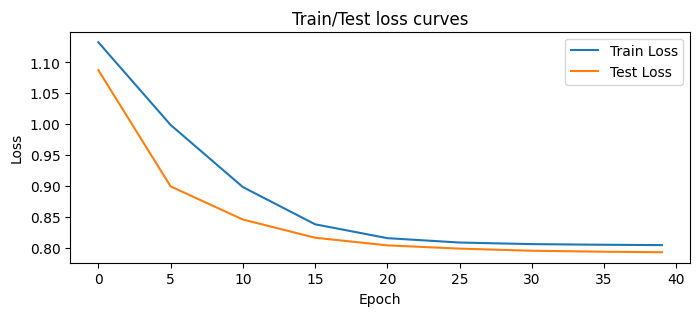

In [158]:
import numpy as np

# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

## Plot Accuracy Curve

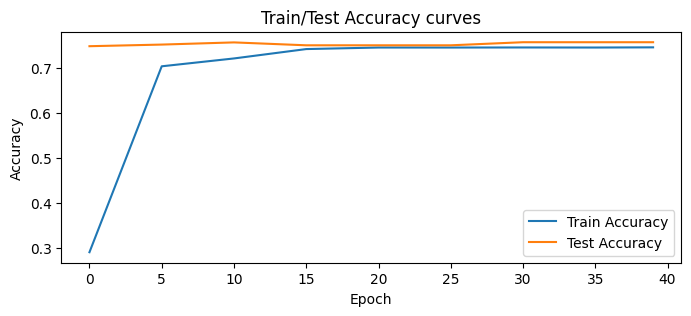

In [164]:
import numpy as np

# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(train_accuracies).numpy()), label="Train Accuracy")
plt.plot(epoch_count, np.array(torch.tensor(test_accuracies).numpy()), label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

## Saving model

In [160]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents = True, exist_ok =True)

model_name = '00_LSTM_HateSpeech.pth'
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj = model.state_dict(),
           f = model_save_path)
print('Saved Successfully')

Saving model to: models/00_LSTM_HateSpeech.pth
Saved Successfully


In [161]:
loaded_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
loaded_model.load_state_dict(torch.load(model_save_path))

# Transfer loaded model to CUDA
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LSTMModel(
  (embedding): Embedding(232337, 100)
  (lstm): LSTM(100, 20, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=20, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)
Model on device:
cuda:0


In [162]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)

y_preds

tensor([[0.0016, 0.9965, 0.0019],
        [0.0016, 0.9965, 0.0019],
        [0.0016, 0.9965, 0.0019],
        ...,
        [0.0016, 0.9965, 0.0019],
        [0.0016, 0.9965, 0.0019],
        [0.1150, 0.0236, 0.8614]], device='cuda:0')

In [163]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        ...,
        [True, True, True],
        [True, True, True],
        [True, True, True]], device='cuda:0')